# Preparing data

In [4]:
import numpy as np
import base64
import os
from os.path import join
import sys

def mprint(msg):
    from datetime import datetime
    """info"""
    cur_time = datetime.now().strftime('%m-%d %H:%M:%S')
    print(f"INFO  [{cur_time}] {msg}")

def Config_DIRS():

    if len(sys.argv) == 1:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'pic': join(ROOT_DIR, 'pic'),
            'submission': join(ROOT_DIR, 'automl')
        }
    elif len(sys.argv) == 3:
        # default local
        ROOT_DIR = os.getcwd()
        DIRS = {
            'input': join(ROOT_DIR, 'data'),
            'output': join(ROOT_DIR, 'predictions'),
            'pic': join(ROOT_DIR, 'pic'),
            'submission': join(ROOT_DIR, 'automl')
        }

    elif len(sys.argv) == 5:
        # run in codalab
        DIRS = {
            'input': sys.argv[1],
            'output': sys.argv[2],
            'program': sys.argv[3],
            'submission': sys.argv[4]
        }
    elif len(sys.argv) == 6 and sys.argv[1] == 'local':
        # full call in local
        DIRS = {
            'input': sys.argv[2],
            'output': sys.argv[3],
            'program': sys.argv[4],
            'submission': sys.argv[5]
        }
    else:
        raise ValueError("Wrong number of arguments")
    sys.path.append(DIRS['submission'])
    print(DIRS)
    return(DIRS)

DIRS = Config_DIRS()

import reader
import json
from util import dump_result,load_result

with open('data_info.json', 'r') as f:
        target_info = json.load(fp=f)
        
#####################################################################

dataname = "jasmine"
niteration= 100
seeds = [1,42,100,2019,10000]
save_pic=True
######################################################################

dataset = dataname
target_name =target_info[dataname]
        
info = {
	"table_sep" : ',',
	"target_name" : target_name,#binaryClass
	"miss_values":'?'
}

reader = reader.Reader(sep = info['table_sep'],
						miss_values=info['miss_values']
						)

#for dataname in datanames:
mprint(f'Read data: {dataname}')
datapath = join(DIRS['input'], dataname+'.csv')
data = reader.read_split([datapath], target_name=info['target_name'])
print(data.keys())


{'input': 'D:\\CaiCai\\MasterThesis_Automl_3.0\\data', 'output': 'D:\\CaiCai\\MasterThesis_Automl_3.0\\predictions', 'pic': 'D:\\CaiCai\\MasterThesis_Automl_3.0\\pic', 'submission': 'D:\\CaiCai\\MasterThesis_Automl_3.0\\automl'}
INFO  [10-19 17:50:26] Read data: jasmine
----------------Start [read_split]:
--------------------Start [pre_clean]:

reading csv : D:\CaiCai\MasterThesis_Automl_3.0\data\jasmine.csv ...
cleaning data ...
--------------------End   [pre_clean]. Time elapsed: 3.22 sec.

> Number of common features : 144

gathering and crunching for train datasets ...
reindexing for train datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> You have no missing values on train set...

dropping columns with high missing rate >0.8...
> No need to dropping!

> Number of categorical features: 0
> Number of numerical features: 144
> Number of training samples : 2984

> Task : classification
Train Traget
0.0    1492
1.0    1492
Name: class, dty

C:\Users\chengfang\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Random Search

In [5]:
from randomsearch import randomsearch
import lightgbm as lgb
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

df_train = data['train'] #df_test = data['test']
y = data['target'] #y_test = data['y_test']

models = {
    'LGBMClassifier': lgb.LGBMClassifier(objective='binary', random_state=0),
    'SVC':SVC(max_iter=1000,random_state=0)
}
               
params = {
    'LGBMClassifier': {'is_unbalance':Categorical(categories=[True, False]),
                     'learning_rate':Real(0.01, 1.0),
                     'boosting_type': Categorical(categories=['gbdt', 'dart']),
                     'n_estimators': Integer(10, 500),
                     'max_bin': Integer(100,10000),
                     'feature_fraction': Real(0.01, 1.0, 'uniform'),
                     'reg_alpha': Real(low=1e-09, high=1000, prior='log-uniform'),
                     'reg_lambda': Real(low=1e-09, high=1000, prior='log-uniform')},
    'SVC': {"class_weight": Categorical(categories=['balanced',None]),
            'C': Real(1e-6, 1e+6, 'log-uniform'),  
            'gamma': Real(1e-6, 1e+1, 'log-uniform'),
            'degree': np.arange(1,8,1), 
            'kernel': Categorical(categories=['linear', 'poly', 'rbf'])}}
random_result_seed={}
for seed in seeds:
    print("")
    print('> start fitting with seed ',seed)
    RM = randomsearch(models, params,random_state=seed,verbose=False)
    random_result=RM.fit(df_train, y,n_iter=niteration,need_callback=True)
    random_result_seed[seed]=random_result
    
cv_res_rm = []
std_res_rm = []
cv_res_RM = {}
for model in random_result_seed[1].keys():
    for gp1, gp2, gp3, gp4, gp5 in zip(random_result_seed[1][model]['all_cv_results'], random_result_seed[42][model]['all_cv_results'],
                                       random_result_seed[100][model]['all_cv_results'], random_result_seed[2019][model]['all_cv_results'],
                                       random_result_seed[10000][model]['all_cv_results']):
        cv_res_rm.append(np.mean(np.array([gp1, gp2, gp3, gp4, gp5])))
        std_res_rm.append(np.std(np.array([gp1, gp2, gp3, gp4, gp5])))
        cv_res_RM['mean_score'] = cv_res_rm
        cv_res_RM['std_score'] = std_res_rm
        
cv_res_RM['CPU_Time']= np.mean([int(np.sum([d['CPU_Time'] for d in random_result_seed[1].values()])),
                                int(np.sum([d['CPU_Time'] for d in random_result_seed[42].values()])),
                                int(np.sum([d['CPU_Time'] for d in random_result_seed[100].values()])),
                                int(np.sum([d['CPU_Time'] for d in random_result_seed[2019].values()])),
                                int(np.sum([d['CPU_Time'] for d in random_result_seed[10000].values()]))
                               ])

cv_res_RM['Time_cost']=np.mean([int(np.sum([d['Time_cost'] for d in random_result_seed[1].values()])),
                                int(np.sum([d['Time_cost'] for d in random_result_seed[42].values()])),
                                int(np.sum([d['Time_cost'] for d in random_result_seed[100].values()])),
                                int(np.sum([d['Time_cost'] for d in random_result_seed[2019].values()])),
                                int(np.sum([d['Time_cost'] for d in random_result_seed[10000].values()]))
                               ])

dump_result(random_result_seed,dataset,"RandomSearch_seed"+str(niteration),save_with_time=False)
dump_result(cv_res_RM,dataset,"rm_summary_seed_"+str(niteration),save_with_time=False)



> start fitting with seed  1

----------------Start [fit]:
INFO  [10-19 17:50:42] Running RandomSearchCV...
Running with Callback function....
Running with Callback function....
Running with Callback function....
Running with Callback function....
Running with Callback function....
Running with Callback function....
Running with Callback function....
Running with Callback function....
Running with Callback function....
Running with Callback function....
Finished, took CPU Time: 0s,clock time: 120s, candidates checked:100 ,best CV score: 0.8097 ± 0.0116


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.809658593522031
Best Model is:
{'boosting_type': 'dart',
 'feature_fraction': 0.3055103418055143,
 'is_unbalance': True,
 'learning_rate': 0.043829598073980666,
 'max_bin': 2344,
 'model': 'LGBMClassifier',
 'n_estimators': 74,
 'reg_alpha': 0.0002257428860366115,
 'reg_lambda': 4.6290787643956206e-07}
----------------End   [fit]. Time elapsed: 121.57 sec.

# Serial BO

In [6]:
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from optimisation_fs import Optimiser
from optimization_combi import automl_Optimiser
from model import Classifier
import pandas as pd
from util import dump_result,load_result

df_train = data['train'] #df_test = data['test']
y = data['target'] #y_test = data['y_test']
search_space_LGB = Classifier(strategy = "LightGBM").get_search_spaces(need_feature_selection=False)
search_space_SVC = Classifier(strategy = "SVC").get_search_spaces(need_feature_selection=False)
results_serial_seed={}
for seed in seeds:
    print("")
    print('> start fitting with seed ',seed)
    optimiser = automl_Optimiser(verbose=0,n_folds=5,parallel_strategy=False,refit=False,random_state=seed,baseEstimator=["GP","RF"])
    best_param_serial,results_serial = optimiser.optimise_step(df_train=df_train,
                                                               df_target=y,
                                                               n_iter = niteration,
                                                               set_callbacks=True,
                                                               npoints=None,
                                                               nrandom=0)
    results_serial_seed[seed]=results_serial

sbo_cv_res = {}
for estmator in ['GP', 'RF']:
    cv_res_gp = []
    std_res_gp = []
    cv_res_GP = {}
    for gp1, gp2, gp3, gp4, gp5 in zip(results_serial_seed[1][estmator]['all_cv_results'], results_serial_seed[42][estmator]['all_cv_results'],
                                       results_serial_seed[100][estmator]['all_cv_results'], results_serial_seed[2019][estmator]['all_cv_results'],
                                       results_serial_seed[10000][estmator]['all_cv_results']):
        cv_res_gp.append(np.mean(np.array([gp1, gp2, gp3, gp4, gp5])))
        std_res_gp.append(np.std(np.array([gp1, gp2, gp3, gp4, gp5])))
        cv_res_GP['mean_score'] = cv_res_gp
        cv_res_GP['std_score'] = std_res_gp
        sbo_cv_res[estmator] = cv_res_GP
    sbo_cv_res[estmator]['CPU_Time']=np.mean([int(results_serial_seed[1][estmator]['CPU_Time']),int(results_serial_seed[42][estmator]['CPU_Time']),
                                   int(results_serial_seed[100][estmator]['CPU_Time']),int(results_serial_seed[2019][estmator]['CPU_Time']),
                                   int(results_serial_seed[10000][estmator]['CPU_Time'])])
    sbo_cv_res[estmator]['Time_cost']=np.mean([int(results_serial_seed[1][estmator]['Time_cost']),int(results_serial_seed[42][estmator]['Time_cost']),
                                   int(results_serial_seed[100][estmator]['Time_cost']),int(results_serial_seed[2019][estmator]['Time_cost']),
                               int(results_serial_seed[10000][estmator]['Time_cost'])])
#     sbo_cv_res[estmator]['sur_clock_time']=np.mean([int(results_serial_seed[1][estmator]['sur_clock_time']),int(results_serial_seed[42][estmator]['sur_clock_time']),
#                                    int(results_serial_seed[100][estmator]['sur_clock_time']),int(results_serial_seed[2019][estmator]['sur_clock_time']),
#                                    int(results_serial_seed[10000][estmator]['sur_clock_time'])])
#     sbo_cv_res[estmator]['ac_clock_time']=np.mean([int(results_serial_seed[1][estmator]['ac_clock_time']),int(results_serial_seed[42][estmator]['ac_clock_time']),
#                                    int(results_serial_seed[100][estmator]['ac_clock_time']),int(results_serial_seed[2019][estmator]['ac_clock_time']),
#                                int(results_serial_seed[10000][estmator]['ac_clock_time'])])
#     sbo_cv_res[estmator]['eval_clock_time']=np.mean([int(results_serial_seed[1][estmator]['eval_clock_time']),int(results_serial_seed[42][estmator]['eval_clock_time']),
#                                    int(results_serial_seed[100][estmator]['eval_clock_time']),int(results_serial_seed[2019][estmator]['eval_clock_time']),
#                                int(results_serial_seed[10000][estmator]['eval_clock_time'])])

#eval_clock_time
#dump_result(results_serial_seed,dataset,"results_serial_seed_"+str(niteration),save_with_time=False)  
#dump_result(sbo_cv_res,dataset,"serial_summary_seed_"+str(niteration),save_with_time=False)


> start fitting with seed  1

----------------Start [optimise_step]:
INFO  [10-19 18:02:20] Start turning Hyperparameters .... 

>>> Categorical Features have encoded with :{'strategy': 'label_encoding'}

INFO  [10-19 18:02:20] start tuning  with Surrogate Model:GP...

took CPU Time: 2091.0s,clock time: 475.0s, candidates checked:100 ,best CV score: 0.87407534 ± 0.0098

INFO  [10-19 18:10:15] start tuning  with Surrogate Model:RF...

took CPU Time: 1835.0s,clock time: 522.0s, candidates checked:100 ,best CV score: 0.8743133 ± 0.008


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.8743133001831861
with Surrogate Model RF
LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.5655938520729822, max_depth=-1,
        min_child_samples=20, min_child_weight=39, min_samples_leaf=8,
        min_samples_split=6, min_split_gain=0.0, n_estimators=194,
        n_jobs=-1, num_leav

# parallel Bayesian Optimization

In [7]:
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from optimisation_fs import Optimiser
from optimization_combi import automl_Optimiser
from model import Classifier
import pandas as pd
from util import dump_result,load_result

#df_train = data['train'] #df_test = data['test']
#y = data['target'] #y_test = data['y_test']

search_space_LGB = Classifier(strategy = "LightGBM").get_search_spaces(need_feature_selection=False)
search_space_SVC = Classifier(strategy = "SVC").get_search_spaces(need_feature_selection=False)
results_seed = {}
for seed in seeds:
    print("")
    print('> start fitting with seed ',seed)
    optimiser = automl_Optimiser(verbose=0,n_folds=5,parallel_strategy=True,refit=False,random_state=seed,baseEstimator=["GP","RF"])
    best_param,results = optimiser.optimise_step( df_train=df_train,
                                                  df_target=y,
                                                  n_iter = niteration,
                                                  set_callbacks=True,
                                                  npoints=6,
                                                  nrandom=0)
    results_seed[seed]=results
    
pbo_cv_res = {}
for estmator in ['GP', 'RF']:
    cv_res_gp = []
    std_res_gp = []
    cv_res_GP = {}
    for gp1, gp2, gp3, gp4, gp5 in zip(results_seed[1][estmator]['all_cv_results'], results_seed[42][estmator]['all_cv_results'],
                                       results_seed[100][estmator]['all_cv_results'], results_seed[2019][estmator]['all_cv_results'],
                                       results_seed[10000][estmator]['all_cv_results']):
        cv_res_gp.append(np.mean(np.array([gp1, gp2, gp3, gp4, gp5])))
        std_res_gp.append(np.std(np.array([gp1, gp2, gp3, gp4, gp5])))
        cv_res_GP['mean_score'] = cv_res_gp
        cv_res_GP['std_score'] = std_res_gp
        pbo_cv_res[estmator] = cv_res_GP
    pbo_cv_res[estmator]['CPU_Time']=np.mean([int(results_seed[1][estmator]['CPU_Time']),int(results_seed[42][estmator]['CPU_Time']),
                                   int(results_seed[100][estmator]['CPU_Time']),int(results_seed[2019][estmator]['CPU_Time']),
                                   int(results_seed[10000][estmator]['CPU_Time'])])
    pbo_cv_res[estmator]['Time_cost']=np.mean([int(results_seed[1][estmator]['Time_cost']),int(results_seed[42][estmator]['Time_cost']),
                                   int(results_seed[100][estmator]['Time_cost']),int(results_seed[2019][estmator]['Time_cost']),
                               int(results_seed[10000][estmator]['Time_cost'])])
#     pbo_cv_res[estmator]['sur_clock_time']=np.mean([int(results_seed[1][estmator]['sur_clock_time']),int(results_seed[42][estmator]['sur_clock_time']),
#                                    int(results_seed[100][estmator]['sur_clock_time']),int(results_seed[2019][estmator]['sur_clock_time']),
#                                    int(results_seed[10000][estmator]['sur_clock_time'])])
#     pbo_cv_res[estmator]['ac_clock_time']=np.mean([int(results_seed[1][estmator]['ac_clock_time']),int(results_seed[42][estmator]['ac_clock_time']),
#                                    int(results_seed[100][estmator]['ac_clock_time']),int(results_seed[2019][estmator]['ac_clock_time']),
#                                int(results_seed[10000][estmator]['ac_clock_time'])])
#     pbo_cv_res[estmator]['eval_clock_time']=np.mean([int(results_seed[1][estmator]['eval_clock_time']),int(results_seed[42][estmator]['eval_clock_time']),
#                                    int(results_seed[100][estmator]['eval_clock_time']),int(results_seed[2019][estmator]['eval_clock_time']),
#                                int(results_seed[10000][estmator]['eval_clock_time'])])
#dump_result(results_seed,dataset,"results_parallel_seed_"+str(niteration),save_with_time=False)
#dump_result(pbo_cv_res,dataset,"parallel_summary_seed_"+str(niteration),save_with_time=False)


> start fitting with seed  1

----------------Start [optimise_step]:
INFO  [10-19 19:20:24] Start turning Hyperparameters .... 

>>> Categorical Features have encoded with :{'strategy': 'label_encoding'}

INFO  [10-19 19:20:24] start tuning  with Surrogate Model:GP...

took CPU Time: 232.0s,clock time: 280.0s, candidates checked:100 ,best CV score: 0.87416925 ± 0.011

INFO  [10-19 19:25:04] start tuning  with Surrogate Model:RF...

took CPU Time: 86.0s,clock time: 207.0s, candidates checked:100 ,best CV score: 0.8765561 ± 0.0111


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.8765560983426954
with Surrogate Model RF
LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.21595879306061488, max_depth=-1,
        min_child_samples=20, min_child_weight=3, min_samples_leaf=3,
        min_samples_split=9, min_split_gain=0.0, n_estimators=220,
        n_jobs=-1, num_leaves=

# BO+ 2random points

In [8]:
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from optimization_combi import automl_Optimiser
from model import Classifier
import pandas as pd
from util import dump_result,load_result

df_train = data['train'] #df_test = data['test']
y = data['target'] #y_test = data['y_test']
search_space_LGB = Classifier(strategy = "LightGBM").get_search_spaces(need_feature_selection=False)
search_space_SVC = Classifier(strategy = "SVC").get_search_spaces(need_feature_selection=False)
results_borm_seed={}

for seed in seeds:
    print("")
    print('> start fitting with seed ',seed)
    optimiser = automl_Optimiser(verbose=0,n_folds=5,parallel_strategy=True,refit=False,random_state=seed,baseEstimator=["GP","RF"])
 
    best_param_borm,results_borm = optimiser.optimise_step(df_train=df_train,
                                                           df_target=y,
                                                           n_iter = niteration,
                                                           set_callbacks=True,
                                                           npoints=6,
                                                           nrandom=2)
    results_borm_seed[seed]=results_borm

pbo_rm_cv_res = {}
for estmator in ['GP', 'RF']:
    cv_res_gp = []
    std_res_gp = []
    cv_res_GP = {}
    for gp1, gp2, gp3, gp4, gp5 in zip(results_borm_seed[1][estmator]['all_cv_results'], results_borm_seed[42][estmator]['all_cv_results'],
                                       results_borm_seed[100][estmator]['all_cv_results'], results_borm_seed[2019][estmator]['all_cv_results'],
                                       results_borm_seed[10000][estmator]['all_cv_results']):
        cv_res_gp.append(np.mean(np.array([gp1, gp2, gp3, gp4, gp5])))
        std_res_gp.append(np.std(np.array([gp1, gp2, gp3, gp4, gp5])))
        cv_res_GP['mean_score'] = cv_res_gp
        cv_res_GP['std_score'] = std_res_gp
        pbo_rm_cv_res[estmator] = cv_res_GP
    pbo_rm_cv_res[estmator]['CPU_Time']=np.mean([int(results_borm_seed[1][estmator]['CPU_Time']),int(results_borm_seed[42][estmator]['CPU_Time']),
                                   int(results_borm_seed[100][estmator]['CPU_Time']),int(results_borm_seed[2019][estmator]['CPU_Time']),
                                   int(results_borm_seed[10000][estmator]['CPU_Time'])])
    pbo_rm_cv_res[estmator]['Time_cost']=np.mean([int(results_borm_seed[1][estmator]['Time_cost']),int(results_borm_seed[42][estmator]['Time_cost']),
                                   int(results_borm_seed[100][estmator]['Time_cost']),int(results_borm_seed[2019][estmator]['Time_cost']),
                               int(results_borm_seed[10000][estmator]['Time_cost'])])

#dump_result(results_borm_seed,dataset,"results_with_parallel_random_"+str(niteration),save_with_time=False)
#dump_result(pbo_rm_cv_res,dataset,"parallel_random_summary_seed_"+str(niteration),save_with_time=False)


> start fitting with seed  1

----------------Start [optimise_step]:
INFO  [10-19 20:00:28] Start turning Hyperparameters .... 

>>> Categorical Features have encoded with :{'strategy': 'label_encoding'}

INFO  [10-19 20:00:28] start tuning  with Surrogate Model:GP...

took CPU Time: 190.0s,clock time: 252.0s, candidates checked:100 ,best CV score: 0.87288454 ± 0.0097

INFO  [10-19 20:04:40] start tuning  with Surrogate Model:RF...

took CPU Time: 86.0s,clock time: 202.0s, candidates checked:100 ,best CV score: 0.87456654 ± 0.0091


######## Congratulations! Here is the Best Parameters: #######
Best Score is: 0.8745665418967675
with Surrogate Model RF
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.7572840595477678,
        max_depth=-1, min_child_samples=20, min_child_weight=0,
        min_samples_leaf=6, min_samples_split=2, min_split_gain=0.0,
        n_estimators=490, n_jobs=-1, num_leaves=31, objective

# Result

## Result 1-- Summary

In [9]:

dump_result(random_result_seed,dataset,"RandomSearch_seed"+str(niteration),save_with_time=False)
dump_result(cv_res_RM,dataset,"rm_summary_seed_"+str(niteration),save_with_time=False)

dump_result(results_serial_seed,dataset,"results_serial_seed_"+str(niteration),save_with_time=False)  
dump_result(sbo_cv_res,dataset,"serial_summary_seed_"+str(niteration),save_with_time=False)
dump_result(results_seed,dataset,"results_parallel_seed_"+str(niteration),save_with_time=False)
dump_result(pbo_cv_res,dataset,"parallel_summary_seed_"+str(niteration),save_with_time=False)
dump_result(results_borm_seed,dataset,"results_parallel_random_seed_"+str(niteration),save_with_time=False)
dump_result(pbo_rm_cv_res,dataset,"parallel_random_summary_seed_"+str(niteration),save_with_time=False)


Dump successful! File Name: jasmine_RandomSearch_seed100.json
Dump successful! File Name: jasmine_rm_summary_seed_100.json
Dump successful! File Name: jasmine_results_serial_seed_100.json
Dump successful! File Name: jasmine_serial_summary_seed_100.json
Dump successful! File Name: jasmine_results_parallel_seed_100.json
Dump successful! File Name: jasmine_parallel_summary_seed_100.json
Dump successful! File Name: jasmine_results_parallel_random_seed_100.json
Dump successful! File Name: jasmine_parallel_random_summary_seed_100.json


In [124]:
from util import dump_result,load_result
import pandas as pd
dataset="abalone"
cv_res_RM=load_result(dataset+"_rm_summary_seed_100.json")
pbo_cv_res=load_result(dataset+"_parallel_summary_seed_100.json")
pbo_rm_cv_res=load_result(dataset+"_parallel_random_summary_seed_100.json")
sbo_cv_res=load_result(dataset+"_serial_summary_seed_100.json")

In [10]:
save_pic = True
rm_cpu_time = np.mean(cv_res_RM['CPU_Time'])
bo_gp_cpu_time = np.mean(pbo_cv_res["GP"]['CPU_Time'])
bo_rf_cpu_time = np.mean(pbo_cv_res["RF"]['CPU_Time'])
bo_rm_gp_cpu_time = np.mean(pbo_rm_cv_res["GP"]['CPU_Time'])
bo_rm_rf_cpu_time = np.mean(pbo_rm_cv_res["RF"]['CPU_Time'])
bo_nopa_gp_cpu_time = np.mean(sbo_cv_res["GP"]['CPU_Time']) 
bo_nopa_rf_cpu_time = np.mean(sbo_cv_res["RF"]['CPU_Time'])

rm_clock_time = np.mean(cv_res_RM['Time_cost'])
bo_gp_clock_time = np.mean(pbo_cv_res["GP"]['Time_cost'])
bo_rf_clock_time = np.mean(pbo_cv_res["RF"]['Time_cost'])
bo_rm_gp_clock_time = np.mean(pbo_rm_cv_res["GP"]['Time_cost'])
bo_rm_rf_clock_time = np.mean(pbo_rm_cv_res["RF"]['Time_cost'])
bo_nopa_gp_clock_time = np.mean(sbo_cv_res["GP"]['Time_cost'])
bo_nopa_rf_clock_time = np.mean(sbo_cv_res["RF"]['Time_cost'])

rm_best_score = round(max(cv_res_RM['mean_score']), 3)
bo_gp_best_score = round(max(pbo_cv_res["GP"]['mean_score']), 3)
bo_rf_best_score = round(max(pbo_cv_res["RF"]['mean_score']), 3)
bo_rm_gp_best_score = round(max(pbo_rm_cv_res["GP"]['mean_score']), 3)
bo_rm_rf_best_score = round(max(pbo_rm_cv_res["RF"]['mean_score']), 3)
bo_nopa_gp_best_score = round(max(sbo_cv_res["GP"]['mean_score']), 3)
bo_nopa_rf_best_score = round(max(sbo_cv_res["RF"]['mean_score']), 3)

summary3 = pd.DataFrame(columns = ["dataset","strategy","best_score","cpu_time","clock_time","iteration"])
summary3["dataset"]=[dataset,dataset,dataset,dataset,dataset,dataset,dataset]
summary3["strategy"]=["randomsearch",'parallel_BO_GP','parallel_BO_RF','parallel_BO+random_GP','parallel_BO+random_RF','serial_BO_GP','serial_BO_RF']
summary3["best_score"]=[rm_best_score,bo_gp_best_score,bo_rf_best_score,bo_rm_gp_best_score,bo_rm_rf_best_score,bo_nopa_gp_best_score,bo_nopa_rf_best_score]
summary3["cpu_time"]=[rm_cpu_time,bo_gp_cpu_time,bo_rf_cpu_time,bo_rm_gp_cpu_time,bo_rm_rf_cpu_time,bo_nopa_gp_cpu_time,bo_nopa_rf_cpu_time]
summary3["clock_time"]=[rm_clock_time,bo_gp_clock_time,bo_rf_clock_time,bo_rm_gp_clock_time,bo_rm_rf_clock_time,bo_nopa_gp_clock_time,bo_nopa_rf_clock_time]
summary3["iteration"]=[len(cv_res_RM['mean_score']),len(pbo_cv_res["GP"]["mean_score"]),len(pbo_cv_res["RF"]["mean_score"]),len(pbo_rm_cv_res["GP"]["mean_score"]),len(pbo_rm_cv_res["RF"]["mean_score"]),len(sbo_cv_res["GP"]["mean_score"]),len(sbo_cv_res["RF"]["mean_score"])]
summary3 = summary3.sort_values(by =["best_score","clock_time"],ascending=[True,False]).reset_index(drop=True)

if save_pic == True:
    file_path = os.path.join(DIRS["pic"],dataset)
    file_name = dataset+"summary.xls"
    if not (os.path.exists(file_path)):
        os.makedirs(file_path)
    elif (os.path.exists(file_path)):
        pass
    df = summary3.sort_values(by =["best_score","clock_time"],ascending=[False,True]).reset_index(drop=True)
    df.to_excel(os.path.join(file_path, file_name))
    print("Save succefully!, ",os.path.join(file_path, file_name))
summary3

Save succefully!,  D:\CaiCai\MasterThesis_Automl_3.0\pic\jasmine\jasminesummary.xls


,dataset,strategy,best_score,cpu_time,clock_time,iteration
0,jasmine,randomsearch,0.809,2.2,139.0,100
1,jasmine,serial_BO_RF,0.864,1427.6,456.0,100
2,jasmine,serial_BO_GP,0.867,2230.0,481.0,100
3,jasmine,parallel_BO_GP,0.868,242.6,287.6,100
4,jasmine,parallel_BO+random_GP,0.868,204.6,269.6,100
5,jasmine,parallel_BO+random_RF,0.868,82.6,202.6,100
6,jasmine,parallel_BO_RF,0.868,85.0,193.6,100


Save succefully!,  D:\CaiCai\MasterThesis_Automl_3.0\pic\jasmine\Seed_summary_jasmine_100


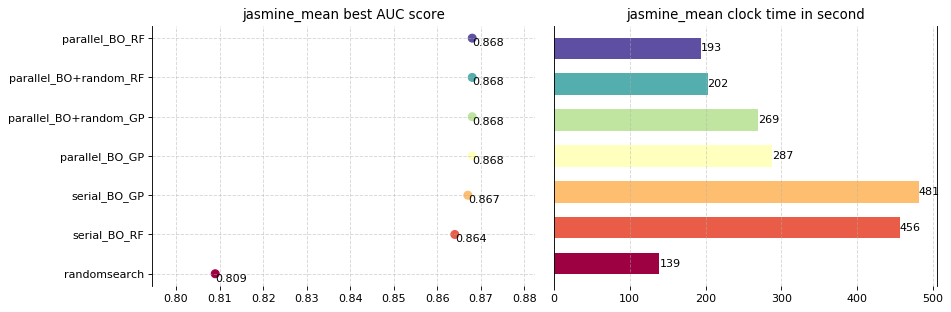

In [17]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

fig = plt.figure(figsize=(12, 4),dpi = 80 )
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
colors = [plt.cm.Spectral(i/float(len(summary3)-1)) for i in range(len(summary3))]

ax.scatter(summary3.best_score,summary3.strategy, s=50,color=colors)
for i, txt in enumerate(summary3.best_score):
    ax.annotate(txt, (summary3.best_score[i], summary3.strategy[i]), horizontalalignment='left',verticalalignment='top')
ax.grid(linestyle='--', alpha=0.5)
#ax.set_xlim(0.95,1.002)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_title(dataset+"_mean best AUC score")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_yticks([])
b = ax1.barh(np.arange(len(summary3.strategy)),summary3.clock_time,color=colors,align='center',height=0.6)

for rect in b:
    w = rect.get_width()
    ax1.text(w, rect.get_y()+rect.get_height()/2, '%d' %
            int(w), ha='left', va='center')
ax1.grid(linestyle='--', alpha=0.5)
ax1.set_title(dataset+"_mean clock time in second")
plt.tight_layout()

file_name= 'Seed_summary_'+dataset+'_'+str(niteration)
file_path =os.path.join(DIRS["pic"],dataset)
if save_pic is True:
    if not (os.path.exists(file_path)):
        os.makedirs(file_path)
    elif (os.path.exists(file_path)):
        pass
    plt.savefig(os.path.join(file_path, file_name))
    print("Save succefully!, ",os.path.join(file_path, file_name))
plt.show()

In [12]:
def plot_convergence(results, name, color='b', ax=None, ls='-', title=None):
    if ax is None:
        ax = fig.add_subplot(1, 1, 1)
#     if title:
#         ax.set_title(title)
#     else:
#         ax.set_title(dataset+ "_Convergence plot")

    ax.set_xlabel("Number of samples ")
    ax.set_ylabel("minmum AUC loss after n samples")
    ax.grid(color='grey', linestyle='--', alpha=0.6)


    if name:
        label_name = name
    else:
        label_name = None

#     if isinstance(results, list):
    curr_max = None
    best_ = []
    for result,std in zip(results["mean_score"],results["std_score"]):
        if curr_max is None:
            curr_max = float(result)
            loss = float(curr_max) - 1
            best_.append([-loss,float(std)])
            # best_std_.append(results[2])
        elif float(result) > float(curr_max):

            curr_max = float(result)
            loss = float(curr_max) - 1
            best_.append([-loss,float(std)])
        else:
            best_.append(best_[-1])

    ax.plot(range(1, len(best_) + 1), np.mat(best_)
            [:, 0], c=color, lw=2, label=label_name, ls=ls)  # marker=".", markersize=12,
    r1 = []
    r2 = []
    for item in best_:
        r1.append(item[0] + item[1])
        r2.append(item[0] - item[1])
    ax.fill_between(range(1, len(best_) + 1), r1,
                    r2, color=color, alpha=0.05)
    if name:
        ax.legend(loc='best')
    plt.tight_layout()
    return ax

Save succefully!,  D:\CaiCai\MasterThesis_Automl_3.0\pic\jasmine\seed_overview_jasmine_100


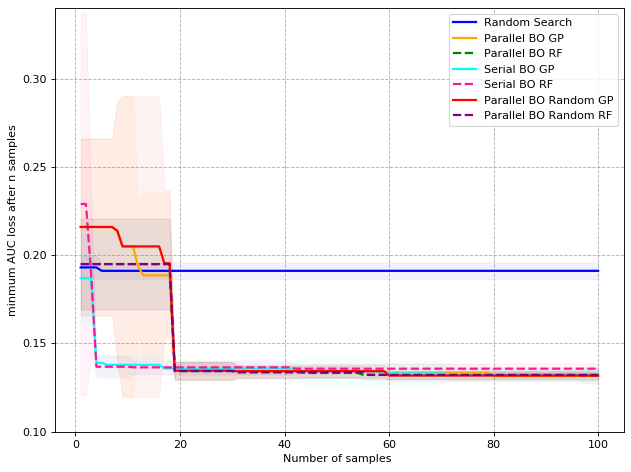

In [13]:
fig = plt.figure(figsize=(8, 6),dpi = 80 )
ax = fig.add_subplot(1,1,1)
ax.set_ylim((0.1,0.34))
#ax.set_xlim((0,40))

plot_convergence(cv_res_RM,'Random Search',ax=ax,color='b')

plot_convergence(pbo_cv_res["GP"],'Parallel BO GP',ax=ax,color='orange')
plot_convergence(pbo_cv_res["RF"],'Parallel BO RF',ax=ax,color='g',ls="--")

plot_convergence(sbo_cv_res["GP"],'Serial BO GP',ax=ax,color='cyan')
plot_convergence(sbo_cv_res["RF"],'Serial BO RF',ax=ax,color='deeppink',ls="--")

plot_convergence(pbo_rm_cv_res["GP"],'Parallel BO Random GP',ax=ax,color='r')
plot_convergence(pbo_rm_cv_res["RF"],'Parallel BO Random RF',ax=ax,color='purple',ls="--")
plt.tight_layout()

file_name= 'seed_overview_'+dataset+'_'+str(niteration)
file_path =os.path.join(DIRS["pic"],dataset)
if save_pic is True:
    if not (os.path.exists(file_path)):
        os.makedirs(file_path)
    elif (os.path.exists(file_path)):
        pass
    plt.savefig(os.path.join(file_path, file_name))
    print("Save succefully!, ",os.path.join(file_path, file_name))
plt.show()

Save succefully!,  D:\CaiCai\MasterThesis_Automl_3.0\pic\jasmine\seed_compareGP-RF_jasmine_100


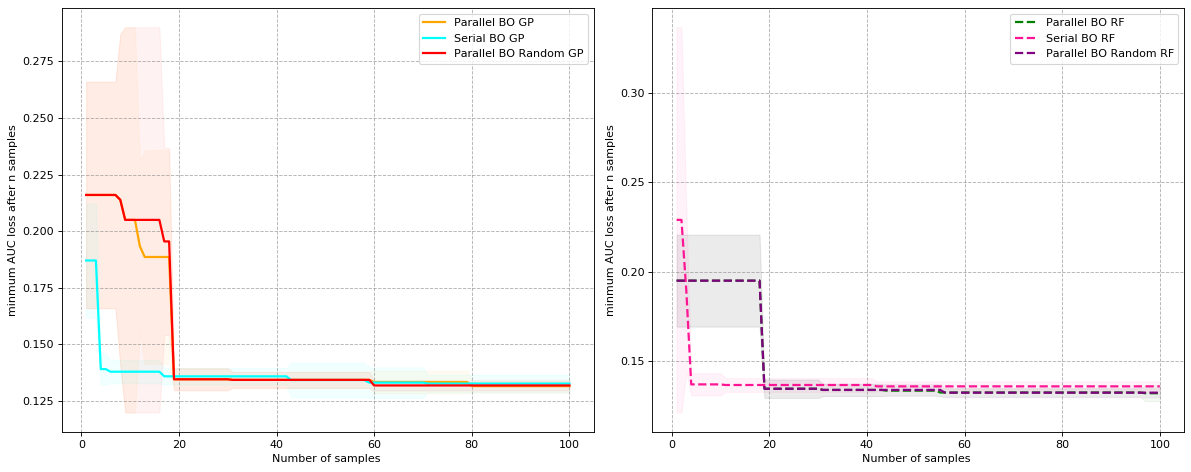

In [14]:
fig = plt.figure(figsize=(15, 6),dpi = 80 )
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
#ax.set_ylim((0.1,0.4))
#ax1.set_ylim((0.1,0.4))
#
#ax.set_xlim((0,40))
#ax1.set_xlim((0,40))

plot_convergence(pbo_cv_res["GP"],'Parallel BO GP',ax=ax,color='orange')
plot_convergence(pbo_cv_res["RF"],'Parallel BO RF',ax=ax1,color='g',ls="--")

plot_convergence(sbo_cv_res["GP"],'Serial BO GP',ax=ax,color='cyan')
plot_convergence(sbo_cv_res["RF"],'Serial BO RF',ax=ax1,color='deeppink',ls="--")

plot_convergence(pbo_rm_cv_res["GP"],'Parallel BO Random GP',ax=ax,color='r')
plot_convergence(pbo_rm_cv_res["RF"],'Parallel BO Random RF',ax=ax1,color='purple',ls="--")

file_name= 'seed_compareGP-RF_'+dataset+'_'+str(niteration)
file_path =os.path.join(DIRS["pic"],dataset)
if save_pic is True:
    if not (os.path.exists(file_path)):
        os.makedirs(file_path)
    elif (os.path.exists(file_path)):
        pass
    plt.savefig(os.path.join(file_path, file_name))
    print("Save succefully!, ",os.path.join(file_path, file_name))
plt.show()

Save succefully!,  D:\CaiCai\MasterThesis_Automl_3.0\pic\jasmine\seed_Clocktime_jasmine_100


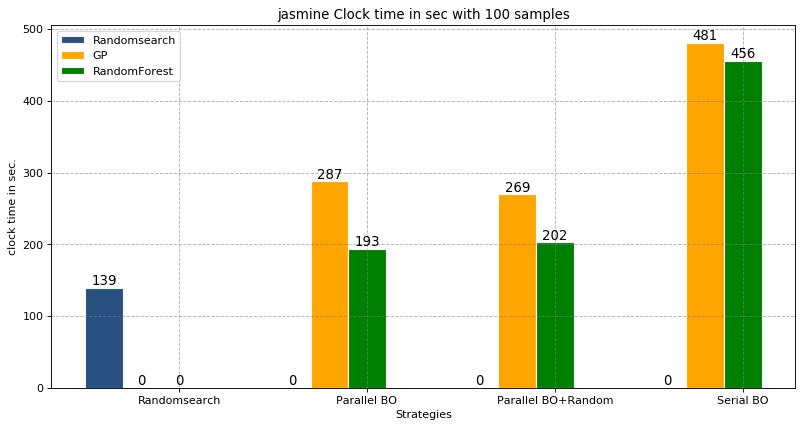

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height,"%d" % height, ha='center', va='bottom',fontsize = 12)
        rect.set_edgecolor('white')

plt.figure(figsize=(12,6),dpi = 80)

x = np.arange(4)
rm_time = cv_res_RM['Time_cost']
rm = [rm_time, 0, 0, 0]

gp = [0, pbo_cv_res["GP"]["Time_cost"],pbo_rm_cv_res["GP"]["Time_cost"],sbo_cv_res["GP"]["Time_cost"]]
#gpwhite = [0,BO_results["GaussianProcessRegressor"]["Time_cost"],BO_rm_results["GaussianProcessRegressor"]["Time_cost"],BO_no_parallel["GaussianProcessRegressor"]["Time_cost"]]
rf = [0, pbo_cv_res["RF"]['Time_cost'],pbo_rm_cv_res["RF"]['Time_cost'],sbo_cv_res["RF"]["Time_cost"]]
bar_width = 0.2
tick_label = ["Randomsearch", "Parallel BO", "Parallel BO+Random", "Serial BO"]

bar_rm = plt.bar(x, rm, bar_width, align="center", color="#0f3d73", label="Randomsearch", alpha=0.9)
#bar_gpwhite = plt.bar(x+2*bar_width, gpwhite, bar_width, color="#c9e0ab", align="center", label="GPWhite")

bar_gp =plt.bar(x+bar_width, gp, bar_width, color="orange", align="center", label="GP")
bar_rf = plt.bar(x+2*bar_width, rf, bar_width, color="green", align="center", label="RandomForest")

add_labels(bar_rm)
add_labels(bar_gp)
#add_labels(bar_gpwhite)
add_labels(bar_rf)

plt.xlabel("Strategies")
plt.ylabel("clock time in sec.")

plt.xticks(x+bar_width*2, tick_label)
plt.title(dataset+' Clock time in sec with '+str(niteration)+" samples")
plt.legend()
plt.grid(color='grey', linestyle='--',alpha=0.6)

file_name= 'seed_Clocktime_'+dataset+'_'+str(niteration)
file_path =os.path.join(DIRS["pic"],dataset)
if save_pic is True:
    if not (os.path.exists(file_path)):
        os.makedirs(file_path)
    elif (os.path.exists(file_path)):
        pass
    plt.savefig(os.path.join(file_path, file_name))
    print("Save succefully!, ",os.path.join(file_path, file_name))
plt.show()

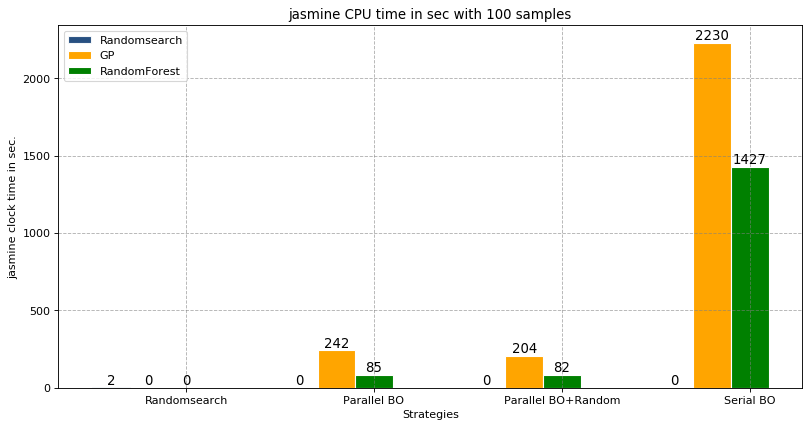

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height,"%d" % height, ha='center', va='bottom',fontsize = 12)
        rect.set_edgecolor('white')


fig=plt.figure(figsize=(12,6),dpi = 80)
x = np.arange(4)
rm_time = cv_res_RM['CPU_Time']
rm = [rm_time, 0, 0, 0]
gp = [0,pbo_cv_res["GP"]["CPU_Time"], pbo_rm_cv_res["GP"]["CPU_Time"], sbo_cv_res["GP"]["CPU_Time"]]
#gpwhite = [0,BO_results["GaussianProcessRegressor"]["CPU_Time"],BO_rm_results["GaussianProcessRegressor"]["CPU_Time"],BO_no_parallel["GaussianProcessRegressor"]["CPU_Time"]]
rf = [0,pbo_cv_res["RF"]["CPU_Time"],pbo_rm_cv_res["RF"]["CPU_Time"],sbo_cv_res["RF"]["CPU_Time"]]
bar_width = 0.2
tick_label = ["Randomsearch", "Parallel BO", "Parallel BO+Random", "Serial BO"]

bar_rm = plt.bar(x, rm, bar_width, align="center", color="#0f3d73", label="Randomsearch", alpha=0.9)
#bar_gpwhite = plt.bar(x+2*bar_width, gpwhite, bar_width, color="#c9e0ab", align="center", label="GPWhite")

bar_gp = plt.bar(x+bar_width, gp, bar_width, color="orange", align="center", label="GP")
bar_rf = plt.bar(x+2*bar_width, rf, bar_width, color="green", align="center", label="RandomForest")

add_labels(bar_rm)
add_labels(bar_gp)
#add_labels(bar_gpwhite)
add_labels(bar_rf)

plt.xlabel("Strategies")
plt.ylabel(dataset+" clock time in sec.")

plt.xticks(x+bar_width*2, tick_label)
plt.title(dataset+' CPU time in sec with '+str(niteration)+" samples")
plt.legend()
plt.grid(color='grey', linestyle='--',alpha=0.6)


file_name= 'seed_CPUtime_'+dataset+'_'+str(niteration)
file_path =os.path.join(DIRS["pic"],dataset)
if save_pic is True:
    if not (os.path.exists(file_path)):
        os.makedirs(file_path)
    elif (os.path.exists(file_path)):
        pass
    plt.savefig(os.path.join(file_path, file_name))
plt.show()